# **Classify coffees with PLS-DA**

> 💡**NOTE:** This document is a Jupyter notebook. You can download the source file and run it in your Jupyter environment!

## **Introduction**
*Can you taste the difference between a coffee from Ethiopia, Brazil, or Vietnam?*

In this tutorial, we will use spectroscopy and machine learning to find the origin of three different coffees produced in:

    🇪🇹 Ethiopia
    🇧🇷 Brazil
    🇻🇳 Vietnam 

These spectra have been collected from brewed coffee using Attenuated Total Reflectance Mid-Infrared Spectroscopy (ATR-MIR). 

In this guide, we'll walk  through the steps to create a classification model that can differenciate the unique fingerprint of each coffee's origin from its spectral signature. 

So, grab your favorite coffee mug, prepare to delve into the world of data-driven discovery, and let's embark on this aromatic journey.

> 💡**NOTE:** In our dataset, we've roasted all the coffee under the same conditions, but here's the twist: Ethiopian and Brazilian beans were brewed into espresso, while Vietnamese coffee was brewed on a moka pot ✨

## **Objective**
In this exercise we will build a PLS-DA model to classify the origin of coffee samples from three different origins.

## **Before starting**
Before we start, you need to be sure to have the following dependencies installed:

```
chemotools
matplotlib
numpy
pandas
scikit-learn
```

You can install them using

```bash
pip install chemotools
pip install matplotlib
pip install numpy
pip install pandas
pip install scikit-learn
```

## **Loading the coffee dataset**
The coffee dataset can be directly accessed from the `chemotools.datasets` module, using the `load_coffee()` function.

In [ ]:
from chemotools.datasets import load_coffee

spectra, labels = load_coffee()

The ```load_coffee()``` function returns two variables: ```spectra``` and ```labels```:

- ```spectra```: A ```pandas.DataFrame``` containing the spectra of the coffee samples as rows.
- ```labels```: A ```pandas.DataFrame``` containing the origin of each sample.

> 💡**NOTE:** If you are interested in working with ```polars.DataFrame``` you can simply use the  ```load_coffee(set_output="polars")```.

## **Explore, plot and color**
Before we dive deep into the coffee data analysis, we will quickly inspect datasets. Let's get a snapshot of the data sizes and kickstart our analysis.

In [ ]:
print(f"The spectra dataset has {spectra.shape[0]} samples")
print(f"The spectra dataset has {spectra.shape[1]} features")

The spectra dataset has 60 samples
The spectra dataset has 1841 features


The ```spectra``` dataset contains 60 samples (rows) and 1841 features (columns). Each sample is a spectrum, and each feature is a wavenumber. The ```labels``` dataset contains the origin of each sample. To analyze the ```labels``` dataset we can use the ```value_counts()``` method from ```pandas``` and make a bar plot.

Text(0.5, 1.0, 'Number of samples per class')

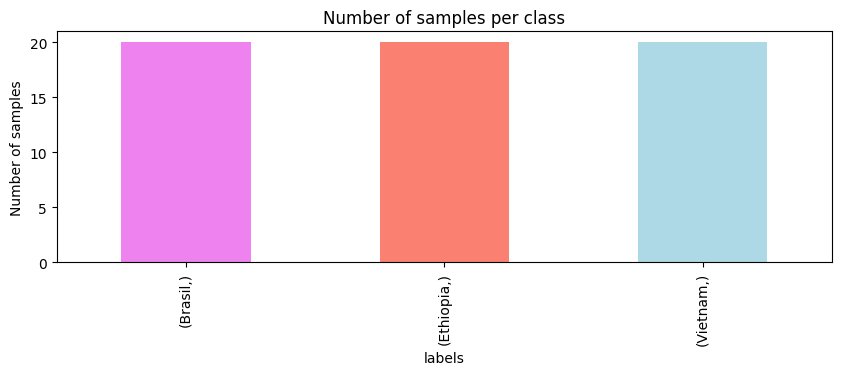

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 3))
labels.value_counts().plot.bar(color=["Violet", "Salmon", "LightBlue"])
ax.set_ylabel("Number of samples")
ax.set_title("Number of samples per class")

We have a balanced dataset with 20 samples per class. Now that we have a better understanding of our data, let's start plotting the spectra. We will plot the different spectra and color them by their origin.

Text(0.5, 1.0, 'Coffee spectra')

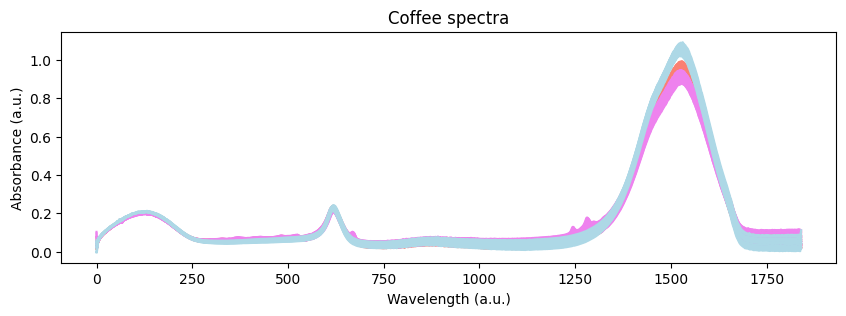

In [ ]:
# define a color dictionary for each origin
color_dict = {
    "Brasil": "Violet",
    "Ethiopia": "Salmon",
    "Vietnam": "LightBlue",
}

fig, ax = plt.subplots(figsize=(10, 3))
for i, row in enumerate(spectra.iterrows()):
    ax.plot(row[1].values, color=color_dict[labels.iloc[i].values[0]])

ax.set_xlabel("Wavelength (a.u.)")
ax.set_ylabel("Absorbance (a.u.)")
ax.set_title("Coffee spectra")

Visually, we can see that there are some differences between the spectra of the three coffees. However, we need to dig deeper to understand the origin of such differences. Let's start with an exploratory analysis. We can do that by using a Principal Component Analysis (PCA) to reduce the dimensionality of the data.

To do so, we will first mean center the data using the ```StandardScaler()``` preprocessing method from ```scikit-learn```. Then, we will use the ```PCA()``` method, also from ```scikit-learn```, to reduce the dimensionality of the data to two principal components. Finally, we will plot the scores and color them according to the origin of the coffee.


> 💡**NOTE:** When using spectroscopic data, we do not want to scale the spectra to unit variance. Instead, we want to mean center the data. This is because the variance of the spectra is related to the absorbance of the sample. If we scale the data to unit variance, we will lose the information about the absorbance of the sample. We can mean center the data using the ```StandardScaler()``` and setting the ```use_std``` argument to ```False```.

Text(0.5, 1.0, 'PCA scores')

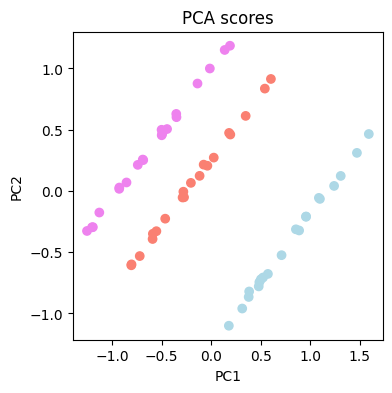

In [ ]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# standardize the data
spectra_scaled = StandardScaler(with_std=False).fit_transform(spectra)

# make a PCA object
pca = PCA(n_components=2)

# fit and transform the data
spectra_pca = pca.fit(spectra_scaled).transform(spectra_scaled)

# Make a dataframe with the PCA scores
spectra_pca_df = pd.DataFrame(
    data=spectra_pca, columns=["PC1", "PC2"], index=spectra.index
)

# Add the labels to the dataframe
spectra_pca_df = pd.concat([spectra_pca_df, labels], axis=1)

# Plot the PCA scores
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    spectra_pca_df["PC1"],
    spectra_pca_df["PC2"],
    c=spectra_pca_df["labels"].map(color_dict),
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA scores")

The results show that there are some differences between the spectra of the three coffes.

## **Preprocessing the spectra**
The objective of the preprocessing is to remove from the spectra non-chemical systematic variation, such as baseline shifts or scattering effects. There has been a lot of research on the preprocessing of spectroscopic data, and this is where ```chemotools``` becomes very handy: we harness the power of such research and make it available to you using  ```scikit-learn``` standards.

We will build the preprocessing steps in a pipeline using the ``` make_pipeline()``` method from ```sklearn.pipeline```. A [pipeline](https://paucablop.github.io/chemotools/get-started/scikit_learn_integration.html#working-with-pipelines) is a sequence of steps that are applied to the data in a given order. In our case, we will apply the following steps:

- __[Standard normal variate (SNV)](https://paucablop.github.io/chemotools/docs/scatter.html#standard-normal-variate)__ to remove scattering effects.

- __[Derivative](https://paucablop.github.io/chemotools/docs/derivative.html#savitzky-golay-derivative)__ to remove both additive and multiplicative scattering effects.

- __[Range cut](https://paucablop.github.io/chemotools/docs/feature_selection.html#range-cut)__ to select the most relevant wavenumbers.

- __[Standardize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)__ remove the mean from the dataset.



In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from chemotools.derivative import SavitzkyGolay
from chemotools.scatter import StandardNormalVariate
from chemotools.feature_selection import RangeCut

pipeline = make_pipeline(
    StandardNormalVariate(),
    SavitzkyGolay(window_size=21, polynomial_order=1),
    RangeCut(start=10, end=1350),
    StandardScaler(with_std=False),
)

preprocessed_spectra = pipeline.fit_transform(spectra)

> 💡**NOTE:** This is cool! See how we are integrating chemometrics with ```scikit-learn```? ```StandardNormalVariate```, and ```SavitizkyGolay``` and ```RangeCut``` are all preprocessing techniques implemented in ```chemotools```, while ```StandardScaler``` and ```pipelines``` are functinlaities provided by ```scikit-learn```. This is the power of ```chemotools```, it is designed to work seamlessly with ```scikit-learn```.

Let's plot the preprocessed spectra to see the effect of the preprocessing steps.

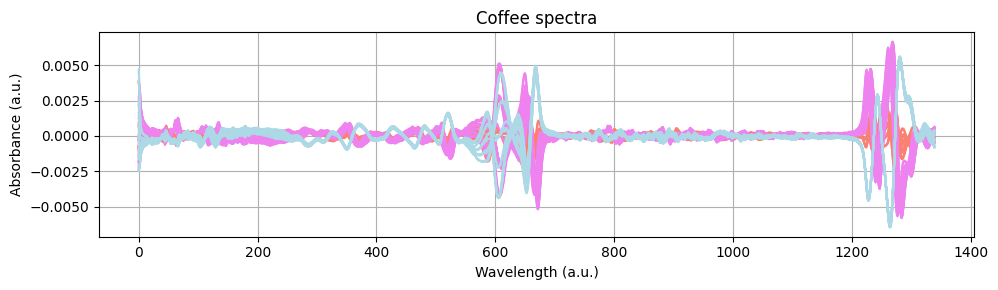

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
for i, spectrum in enumerate(preprocessed_spectra):
    ax.plot(spectrum, color=color_dict[labels.iloc[i].values[0]])
ax.set_xlabel("Wavelength (a.u.)")
ax.set_ylabel("Absorbance (a.u.)")
ax.set_title("Coffee spectra")
ax.grid()
plt.tight_layout()
plt.show()

## __Building a classifier__
In this section, we'll dive into the world of classification. Our goal? To create a classification model that can distinguish the origins of our coffees using their spectral signatures.

Partial Least Squares Discriminant Analysis (PLS-DA) is a simple statistical technique used for classification. PLS-DA models the relationship between input variables (spectral data) and class labels (coffee origins), allowing it to classify new samples based on their spectral signatures with high accuracy. It's a powerful tool for pattern recognition in complex datasets, making it ideal for our coffee origin classification. 

Before we start our PLS-DA algorithm, we need to encode the labels into numbers. We can do that using the ```LabelEncoder()``` method from ```scikit-learn```.

```LabelEncoder()``` will assign a categorical value to each of the labels in our dataset (0 for Brasil, 1 for Ethiopia an 2 for Vietnam).


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make Label Encoder
level_encoder = LabelEncoder()

# Fit the Label Encoder
level_encoder.fit(labels.values.ravel())

# Transform the labels
labels_encoded = level_encoder.transform(labels.values.ravel())

Now that our coffee origin labels have been encoded into numerical values, we are ready to train our PLS-DA model. However, before we start,  we will divide our data into a training and a testing sets using the ```train_test_split()``` method from the ```scikit-learn``` library.

Our strategy is to allocate 80% of our dataset for training our model, allowing it to learn from disticnt features from spectral data, while reserving the remaining 20% for testing. This division ensures that our model's performance can be evaluated on unseen data, a crucial step in assessing its real-world applicability and predictive power.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_spectra, labels_encoded, test_size=0.2, random_state=42
)

> 💡**NOTE:** We set the ```random_state``` argument to 42 to ensure reproducibility of the results.

Now that we have our training and testing sets, we can start building our PLS-DA model. We will use the ```PLSRegression()``` method from ```scikit-learn```. We will set the number of components to 2 and the ```scale``` argument to ```False```. This is because we have already scaled the data in the preprocessing step.

In [ ]:
from sklearn.cross_decomposition import PLSRegression

# Make a PLSRegression object
pls = PLSRegression(n_components=2, scale=False)

# Fit the PLSRegression object to the training data
pls.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = pls.predict(X_test)

> 💡**NOTE:** We have chosen two components because from our PCA analysis we saw that using two components we can separate the three classes.

Now that we have trained our model, we can evaluate its performance. We will use the [accuracy score ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) methods from ```scikit-learn``` to evaluate the performance of the model.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy: ", accuracy_score(y_test, y_pred.round()))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred.round()))

Accuracy:  1.0
Confusion matrix: 
 [[2 0 0]
 [0 4 0]
 [0 0 6]]


## **Recap**
- __The Coffee Dataset:__ Explore the unique world of coffee differentiation through Infrared Spectroscopy. This dataset contains IR spectra of coffee samples from Ethiopia, Brazil, and Vietnam.

- __Importing the Data:__ Effortlessly load the coffee spectra into a Pandas DataFrame using chemotools, making data analysis a breeze.

- __Explore, Plot, and Color:__ Gain insights into the dataset's size and composition, showcasing its 60 samples and 1841 features. Visualize the data with colorful coffee spectra plots.

- __Preprocessing the Spectra:__ Dive into the world of preprocessing, where chemotools comes into play. Eliminate non-chemical systematic variations using techniques like Standard Normal Variate (SNV), Derivative, Range Cut, and Standardization.

- __Modelling the Data:__ Enter the realm of machine learning with Partial Least Squares Discriminant Analysis (PLS-DA), a powerful tool for classification. Encode labels into numerical values and split the data into training and testing sets. Train the model and evaluate its performance, achieving an impressive confusion matrix.

This tutorial showcases the beauty of data science and chemistry, bringing the art of coffee classification to life within the rich world of spectral data.